In [44]:
# dependencies
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import math
import numpy as np

# How does rainfall in Mangona affect lake level at Bilancino?

What we know:

- The latitude, longitude, and elevation of Mangona, Italy
- The amount of rain that fell each day in Mangona
- The air temperature each day in Le Croci (~7.7km away)
- The level of Lake Bilancino each day (~9.3km away from Mangona)

![mappy](images/mangona-lecroci-bilancino.png)

How *should* we compute this? Using the following equation:

$$
R = P - E - G
$$

where:

- $R$ is surface runoff (ie, how much water went into the lake?)
- $P$ is precipitation (assuming rainfall at Mangona was the only precipitation)
- $E$ is evapotranspiration (how much water went back into the sky?)
- $G$ is groundwater recharge (how much water soaked into the ground?)

## Step 1: Clean Our Data

In [2]:
df = pd.read_csv('data/raw/lake/bilancino.csv')

First, use `Date` as the dataset's index for each row (and make sure it's actually a "date" object, instead of a string or generic "object"):

In [3]:
df.index = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.index.name = None

# make sure to note that the frequency of these dates is daily
df.index.freq = 'D'

# we now no longer need the `Date` column
df = df.drop('Date', axis=1)

Next, confirm that we are not missing any dates

In [4]:
last = None
for current in df.index.values:
    
    # if we're not on the first date in our dataset,
    # then confirm that it is exactly one day ahead
    # of the previous date
    if last is not None:
        
        # create a "time delta" of one day
        td = pd.Timedelta('1D')
        
        # determine what the current time "should" be
        now = last + td
        
        # compare that the current is what it should be
        assert current == now
    
    # before we go on to the next date, save the
    # current one so that we can do this comparison again
    last = current

How many values are missing from the dataset?

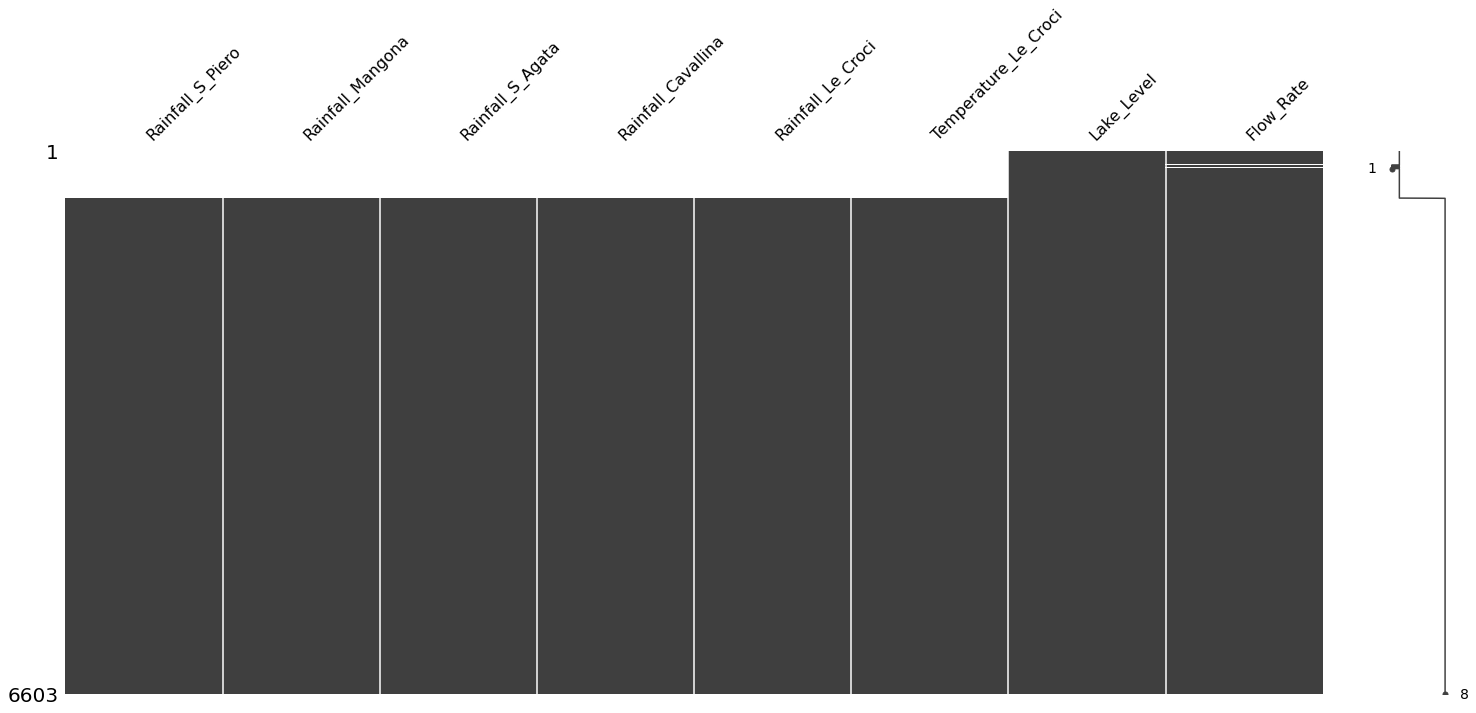

In [5]:
msno.matrix(df)
plt.show()

It looks like we have no non-target data prior to January 2, 2004; let's drop all of those older rows

In [6]:
df = df[df.index > pd.Timestamp('2004-1-1')]

# make sure we no longer have any missing values
assert df.isnull().sum().sum() == 0

Per the dataset description file that was included in the competition, we should only consider the absolute values of the `Rainfall`, `Lake_Level`, and `Flow Rate` columns.

In [7]:
for col in df.columns:
    
    # DON'T take the absolute value of the temperature column
    if col.startswith('Temperature'):
        continue
    
    else:
        df[col] = df[col].abs()

We are only interested in three columns: rainfall at Mangona, temperature at Le Croci, and lake level

In [8]:
df = df[['Rainfall_Mangona', 'Temperature_Le_Croci', 'Lake_Level']]

We now aggregate our data so that we are dealing with everything on a (*calendar*) month-by-month basis

In [9]:
df['Month'] = df.index.month
df['Year'] = df.index.year
df = df.groupby(['Year', 'Month'])

# use the TOTAL rain that fell, but only
# the AVERAGE temperature and lake level for each month
df = pd.DataFrame({
    'Rainfall': df['Rainfall_Mangona'].sum(),
    'Temperature': df['Temperature_Le_Croci'].mean(),
    'Level': df['Lake_Level'].mean()
})

# turn year/month back into columns, instead of row indices
df = df.reset_index()

In [10]:
df.head()

,Year,Month,Rainfall,Temperature,Level
0,2004,1,149.2,4.195000,251.677667
1,2004,2,162.8,6.181034,251.823103
2,2004,3,69.4,8.251613,251.870968
3,2004,4,84.8,12.441667,251.973667
4,2004,5,146.8,14.679032,252.077097


## Step 2: Explore Our Data

![total rainfall each month](images/mangona_monthly.png)

![monthly temperature](images/lecroci_temp_monthly.png)

![lake level all-time](images/level1.png)

![lake level monthly](images/levels2a.png)

## Step 3: Calculate $P$

In order to turn the rainfall levels into a total volume of water, we need to know the total area that was rained on. This amounts to determining the catchment for Mangona.

We know that, ultimately, Lake Bilancino is part of [the catchment for the Arno river](https://www.researchgate.net/figure/Map-showing-the-Arno-river-catchment-and-its-major-tributaries-the-largest-towns-and_fig1_233821084), and that Mangona, ultimately, is part of the catchment for Bilancino; what remains is to determine the square meter-age of this last subcatchment.

Thanks to a [detailed topological map of Tuscany](https://en-gb.topographic-map.com/maps/jcac/Tuscany/) and the distance-measuring tools of [uMap](https://umap.openstreetmap.fr/), we can see that Mangona lies in a small bowl with a radius of approximately 760m.

Thanks to geometry, we know that Mangona has a catchment area of roughly **1.81km²**; as the rainfall column tells us the depth of the rainfall, we simply multiply by the area to determine total volume

We now create a new column in our dataset for $P$, using units of m³

In [17]:
area = math.pi * 760 ** 2
df['P'] = df['Rainfall'] / 1000 * area
df.head()

,Year,Month,Rainfall,Temperature,Level,P
0,2004,1,149.2,4.195000,251.677667,270735.920374
1,2004,2,162.8,6.181034,251.823103,295414.261641
2,2004,3,69.4,8.251613,251.870968,125932.123820
3,2004,4,84.8,12.441667,251.973667,153876.716137
4,2004,5,146.8,14.679032,252.077097,266380.918974


## Step 4: Calculate E

The [climate-indices](https://climate-indices.readthedocs.io/en/latest/) Python package allows us to use the Thornthwaite method for calculating the potential evapotranspiration index of a given location.

The code required to compute the index is beyond the scope of this notebook, but a [GitHub repository](https://github.com/cshields143/bilancino_pet) contains all of the gory details.

![Results of evapotranspiration calculation](images/evapotrans.png)

The units of measurement are mm/month, so--just as with $P$--we multiply by the catchment to determine total volume of water lost (making sure the unit is, again, m³)

In [27]:
pet = pd.read_csv('data/pet.csv', index_col=0)
df['E'] = pet['pet'] / 1000 * area
df.head()

,Year,Month,Rainfall,Temperature,Level,P,E
0,2004,1,149.2,4.195000,251.677667,270735.920374,11786.290808
1,2004,2,162.8,6.181034,251.823103,295414.261641,21494.299015
2,2004,3,69.4,8.251613,251.870968,125932.123820,42126.389632
3,2004,4,84.8,12.441667,251.973667,153876.716137,86026.439794
4,2004,5,146.8,14.679032,252.077097,266380.918974,125558.209223


## Step 5: Calculate $G$

The final piece of our equation--"how much water seeped into the ground, never to be seen again?"--is possibly the most complicated and difficult to calculate. There are several factors to be taken into account:

- How *porous* and *permeable* is the geology? Manmade structures such as roads and parking lots are notoriously impermeable, allowing all the water to runoff elsewhere
- How *saturated* is the ground, currently? If there's already too much water underground, then again all the water will runoff somewhere else
- What is the *temperature* at the time? As we shall see, temperature can actually impact the porosity and permeability of the geology

Apparently, [Mangona has a population of approximately 21 people](http://italy.places-in-the-world.com/8975438-place-Mangona.html); [satellite imagery from Google Maps](https://www.google.com/maps/@44.0418127,11.2004629,815m/data=!3m1!1e3) seems to confirm that the area has undergone very little human development.

Using [hydrological data from Regione Toscana](https://www502.regione.toscana.it/geoscopio/geologia.html), we can conclude that there is no significant groundwater under Mangona.

All this leaves is to determine the geological properties of the ground itself.

Rocks are really, really complicated. It cannot be overstated just how complicated rocks are.

Thanks to geological data again provided by Regione Toscana as well as a [geological map of the Northern Appennines](https://www.geological-map.it/), we can conclude that Mangona is part of what geologists colloquially refer to as "the Cervarola-Falterona Succession".

And thanks to a passing mention in the seminal [Geologic Problem Solving with Microfossils](https://books.google.com/books?id=-AFkJkSUdDMC), we know that the Cervarola-Falterona Succession is comprised of *marl* and *sandstone*.

To better understand why this data is so depressing, we must refresh our memory of high school sedimentary geology.

### But why marl models?

"Sedimentary rock" is slowly built up over time by bits of other rocks all lying on top of each other. Why don't these pebbles just scatter away as soon as they're deposited? Because of processes known as "diagenesis" and "cementation". Basically, while the pebbles are sitting on top of each other, chemical reactions occur which "glue" these rocks together.

There are two common "glues" that can turn a pile of many rocks into one giant sedimentary rock: *silicates* and *carbonates*

This is important for two reasons:

1. Silicate and carbonate rocks have very different porosity/permeability properties; silicates are often more permeable, while such a straightforward answer is not really possible for carbonates; even the temperature of the air can affect how permeable carbonate sediment is

2. Marl is an example of carbonate sediment; sandstone is an example of silicate sediment

Even in an area as small and confined as Mangona, permeability is, to be blunt, a nightmare to figure out.

The standard unit of measurement for geological permeability is the millidarcy; [crowd-sourced knowledge-base management resources](https://en.wikipedia.org/wiki/Permeability_(Earth_sciences)) indicate that the permeability of sandstone can range anywhere from 1 to 1000 millidarcys, whereas the permeability of dolomite and limestone (carbonates) is far lower, from 1% to 10% of a single millidarcy.

### Darcy's Law

We can use Darcy's Law to calculate how much water was lost to the soil:

$$
Q = \frac{Ak \Delta P}{\mu \Delta x}
$$

Where:

- $Q$ is the rate of water lost per day
- $A$ is the surface area of the ground
- $k$ is the permeability of the surface
- $\Delta P$ is the "applied pressure difference"
- $\mu$ is the dynamic viscosity of water
- $\Delta x$ is the *thickness* of the ground

This is all quite complicated, but many of the terms will cancel out. Assuming permeability of 1md, pressure of 1atm, a viscosity for water of 1cP, and a thickness of 25m, we have:

$$
Q = \frac{Surface Area}{25}
$$

In our case, this yields approximately 72,500m³ per day

In [30]:
df['G'] = area / 25
df.head()

,Year,Month,Rainfall,Temperature,Level,P,E,G
0,2004,1,149.2,4.195000,251.677667,270735.920374,11786.290808,72583.356669
1,2004,2,162.8,6.181034,251.823103,295414.261641,21494.299015,72583.356669
2,2004,3,69.4,8.251613,251.870968,125932.123820,42126.389632,72583.356669
3,2004,4,84.8,12.441667,251.973667,153876.716137,86026.439794,72583.356669
4,2004,5,146.8,14.679032,252.077097,266380.918974,125558.209223,72583.356669


## Step 6: Calculate R, Verify Results

In [31]:
df['R'] = df['P'] - df['E'] - df['G']
df.head()

,Year,Month,Rainfall,Temperature,Level,P,E,G,R
0,2004,1,149.2,4.195000,251.677667,270735.920374,11786.290808,72583.356669,186366.272897
1,2004,2,162.8,6.181034,251.823103,295414.261641,21494.299015,72583.356669,201336.605958
2,2004,3,69.4,8.251613,251.870968,125932.123820,42126.389632,72583.356669,11222.377519
3,2004,4,84.8,12.441667,251.973667,153876.716137,86026.439794,72583.356669,-4733.080326
4,2004,5,146.8,14.679032,252.077097,266380.918974,125558.209223,72583.356669,68239.353082


![RESULTS](images/final.png)

In order to verify our results, we must turn lake level into volume of water--and as we are interested in the water *budget*, we only need changes in volume. (It has been noted that the surface area of Lake Bilancino is approximately 5km²)

In [39]:
df['Shifted'] = df['Level'].shift(1)
df = df.dropna()
df['Change'] = df['Level'] - df['Shifted']
df['VolumeChange'] = df['Change'] * 5000
df.head()

,Year,Month,Rainfall,Temperature,Level,P,E,G,R,Shifted,Change,VolumeChange
1,2004,2,162.8,6.181034,251.823103,295414.261641,21494.299015,72583.356669,201336.605958,251.677667,0.145437,727.183908
2,2004,3,69.4,8.251613,251.870968,125932.123820,42126.389632,72583.356669,11222.377519,251.823103,0.047864,239.321468
3,2004,4,84.8,12.441667,251.973667,153876.716137,86026.439794,72583.356669,-4733.080326,251.870968,0.102699,513.494624
4,2004,5,146.8,14.679032,252.077097,266380.918974,125558.209223,72583.356669,68239.353082,251.973667,0.103430,517.150538
5,2004,6,29.8,20.098333,251.968667,54074.600718,204514.538775,72583.356669,-223023.294726,252.077097,-0.108430,-542.150538


Last but not least, we compare our calculated $R$ to the change in volume:

![RESULTS2](images/results.png)

# Postscript: An Attempt at Self-Criticism

Almost everything about this notebook is wrong; let it fall, stillborn, from the internet.

How can it be improved?

- As can be seen from the decrease in lake level in 2012, as well as the consistent lowering in winter when there's *more* rain and *less* heat, an enormous confounding factor is **water removed from the lake for human consumption**. That would add another term to our equation and would yield *far* more reliable results

- Calculating $P$ with a simple "here's the radius of a meaningless circle" can be improved by determining the extent of the rain that actually fell, rather than assuming it fell at the same rate in an arbitrary area. There *must* be a more accurate way to determine the surface area of rainfall, allowing us to create more accurate volumes from the pluviometro at any station

- The only reason to prefer Thornthwaite's equation for potential evapotranspiration is that it requires temperature and nothing more. Literally almost any other index would be more accurate--SPEI, PHDI, Penman-Monteith, take your pick

- Once a better calculation is used for $E$, we must also understand that it is only *potential* $E$; at best, a maximum; further calibration is required to turn this into an empirical value

- *Is* there groundwater under Mangona? What exactly is the geology, and therefore the permeability? Darcy's law is not actually that helpful, but **substantial** field measurements would need to be made to come up with anything close to actual measurements or calculations